In [ ]:
!pip install  imageio
!pip install opencv-python
!pip install  git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ncusuysc
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ncusuysc
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=162411 sha256=571a16121a0549b8834dd18bec8d0ed8ed74fffb6c86c5c746b7b43fd7b42a72
  Stored in directory: /tmp/pip-ephem-wheel-cache-9fknqp96/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
from tqdm import tqdm
import random

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches
import imageio
from IPython.display import HTML, display

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import keras
from keras.models import Sequential

from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
KEYPOINT_DICT = {
    'nose': 0,'left_eye': 1,'right_eye': 2,'left_ear': 3,'right_ear': 4,'left_shoulder': 5,
    'right_shoulder': 6,'left_elbow': 7,'right_elbow': 8,'left_wrist': 9,'right_wrist': 10,
    'left_hip': 11,'right_hip': 12,'left_knee': 13,'right_knee': 14,'left_ankle': 15,
    'right_ankle': 16
}

KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',(0, 2): 'c',(1, 3): 'm',(2, 4): 'c',(0, 5): 'm',(0, 6): 'c',
    (5, 7): 'm',(7, 9): 'm',(6, 8): 'c',(8, 10): 'c',(5, 6): 'y',(5, 11): 'm',
    (6, 12): 'c',(11, 12): 'y',(11, 13): 'm',(13, 15): 'm',(12, 14): 'c',(14, 16): 'c'
}

In [ ]:
def _keypoints_and_edges_for_display(keypoints_with_scores,
         height,width,keypoint_threshold=0.11):

  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):

  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot


def to_gif(images, fps):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('/content/drive/MyDrive/Drunk_distraction/gif/animation.gif', images, fps=fps)
  return embed.embed_file('/content/drive/MyDrive/Drunk_distraction/gif/animation.gif')


def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [ ]:
model_name = "movenet_thunder_int8.tflite" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):

    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):

    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoint_with_scores = outputs['output_0'].numpy()
    return keypoint_with_scores

In [ ]:
def overlay(image):
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoint_with_scores = movenet(input_image)

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(
        display_image,128,128), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(
        np.squeeze(display_image.numpy(), axis=0), keypoint_with_scores)

    return output_overlay
def overlay2(image):
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference.
    keypoint_with_scores = movenet(input_image)

    # Visualize the predictions with image.
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(
        display_image, 128, 128), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(
        np.squeeze(display_image.numpy()*0, axis=0), keypoint_with_scores)

    return output_overlay

In [ ]:
data_dir='/content/drive/MyDrive/Drunk_distraction /imgs/train/c1'
files=os.listdir(data_dir)
# print(files[0:5])

In [ ]:
paths=[]
for item in files:
    paths+=[os.path.join(data_dir,item)]
plt.figure(figsize=(5,5))
imageT0 = tf.io.read_file(paths[1])
imageT = tf.image.decode_jpeg(imageT0)
print(type(imageT))
plt.imshow(imageT)
_ = plt.axis('off')
plt.figure(figsize=(5,5))
#imageT0 = tf.io.read_file(image_path)
#imageT = tf.image.decode_jpeg(imageT0)
output_overlay=overlay(imageT)
print(np.shape(output_overlay))
plt.imshow(output_overlay)
_ = plt.axis('off')
plt.figure(figsize=(5,5))
#imageT0 = tf.io.read_file(image_path)
#imageT = tf.image.decode_jpeg(imageT0)
output_overlay=overlay2(imageT)
plt.imshow(output_overlay)
_ = plt.axis('off')

**Multiclass_viszulaixation**

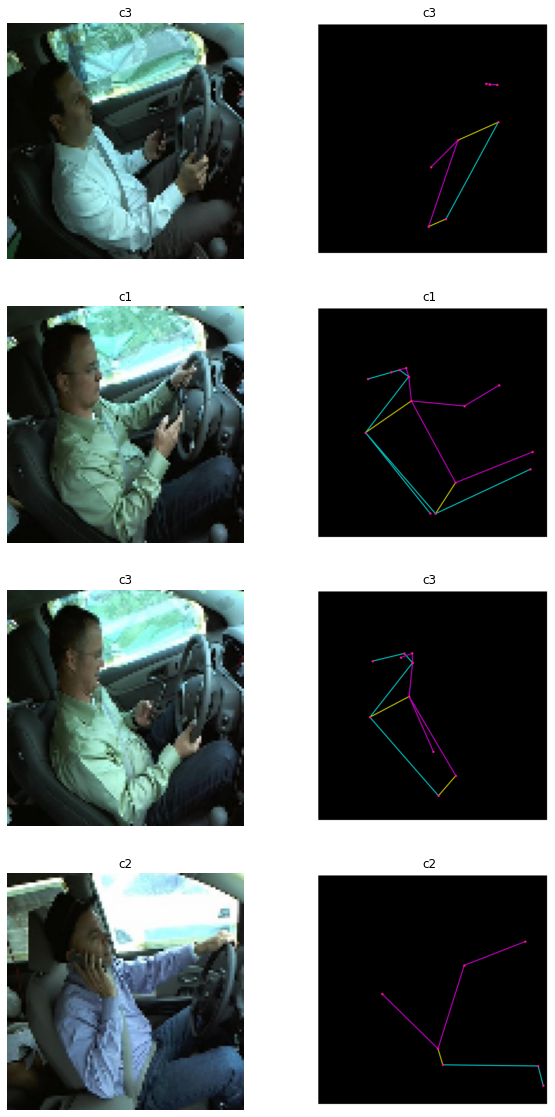

In [ ]:
train_dir = '/content/drive/MyDrive/Drunk_distraction /imgs/train/c0'
Name0=[]
for file in os.listdir(train_dir):
    Name0+=[file]
Name=sorted(Name0)
print(Name)
print(len(Name))
N=list(range(len(Name)))
normal_mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 
trainset=list()
trainset2=list()
trainname=list()
for name in tqdm(Name):
    path=os.path.join(train_dir,name)
    for i in range(10):
        im=os.listdir(path)[i]
        img1=cv2.imread(os.path.join(path,im))
        img2=cv2.resize(img1,dsize=(100,100),interpolation=cv2.INTER_CUBIC)
        img3=overlay2(img2)
        trainset.append(img3)
        trainset2.append(img2)
        trainname.append(name)
trainX=np.array(trainset)
trainX2=np.array(trainset2)
trainY0=pd.Series(trainname).map(normal_mapping)
m=len(trainX)
M=list(range(m))
random.seed(2022)
random.shuffle(M)
fig, axs = plt.subplots(4,2,figsize=(10,20))
for i in range(4):
    ax=axs[i][0].axis("off")
    ax=axs[i][0].set_title(trainname[M[i]])
    ax=axs[i][0].imshow(cv2.cvtColor(trainX2[M[i]],cv2.COLOR_BGR2RGB))
    ax=axs[i][1].axis("off")
    ax=axs[i][1].set_title(trainname[M[i]])
    ax=axs[i][1].imshow(trainX[M[i]])
plt.show()

**Keypoints_saving**

In [ ]:
import cv2
from PIL import Image
image=cv2.imread('/content/drive/MyDrive/Drunk_distraction /imgs/train/c0/img_100026.jpg')
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
# Run model inference.
keypoint_with_scores = movenet(input_image)
# print(keypoint_with_scores)
print(np.shape(keypoint_with_scores))
img=np.reshape(keypoint_with_scores,(1,17,3))
img_gray = np.mean(img, axis=2)
print(np.shape(img_gray))
print(img_gray)

(1, 1, 17, 3)
(1, 17)
[[0.40583274 0.4757638  0.48609528 0.39800254 0.4389484  0.51956636
  0.49030307 0.48333308 0.54243857 0.5330417  0.57237864 0.6144616
  0.6389253  0.58950764 0.65880877 0.55441195 0.5638686 ]]


In [ ]:
image_dir='/content/drive/MyDrive/Drunk_distraction /imgs/train/c0/'
save_dr='/content/drive/MyDrive/Drunk_distraction /gif/c0/'
files=os.listdir(image_dir)
# print(files)
c0_t=[]
for i in range(1000):
    img=os.path.join(image_dir+files[i])
    image=cv2.imread(img)
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
    # Run model inference.
    keypoint_with_scores = movenet(input_image)
    # print(keypoint_with_scores)
    img=np.reshape(keypoint_with_scores,(1,17,3))
    img_gray = np.mean(img, axis=2)
    c0_t.append(img_gray)
    print("done")
c0_t=np.reshape(c0_t,(1000,1,17))
np.save(save_dr+'c0_t',c0_t)



In [ ]:
image_dir='/content/drive/MyDrive/Drunk_distraction /imgs/train/c1/'
save_dr='/content/drive/MyDrive/Drunk_distraction /gif/'
files=os.listdir(image_dir)
print(len(files))
c0_t=[]
for i in range(1000):
    img=os.path.join(image_dir+files[i])
    image=cv2.imread(img)
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
    # Run model inference.
    keypoint_with_scores = movenet(input_image)
    # print(keypoint_with_scores)
    img=np.reshape(keypoint_with_scores,(1,17,3))
    img_gray = np.mean(img, axis=2)
    c0_t.append(img_gray)
    print("done")
c0_t=np.reshape(c0_t,(1000,1,17))
np.save(save_dr+'c1_t',c0_t)



In [ ]:
image_dir='/content/drive/MyDrive/Drunk_distraction /imgs/train/c2/'
save_dr='/content/drive/MyDrive/Drunk_distraction /gif/'
files=os.listdir(image_dir)
print(len(files))
c0_t=[]
for i in range(1000):
    img=os.path.join(image_dir+files[i])
    image=cv2.imread(img)
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
    # Run model inference.
    keypoint_with_scores = movenet(input_image)
    # print(keypoint_with_scores)
    img=np.reshape(keypoint_with_scores,(1,17,3))
    img_gray = np.mean(img, axis=2)
    c0_t.append(img_gray)
print("done")
c0_t=np.reshape(c0_t,(1000,1,17))
np.save(save_dr+'c2_t',c0_t)



1783
done


In [ ]:
image_dir='/content/drive/MyDrive/Drunk_distraction /imgs/train/c3/'
save_dr='/content/drive/MyDrive/Drunk_distraction /gif/'
files=os.listdir(image_dir)
print(len(files))
c0_t=[]
for i in range(1000):
    img=os.path.join(image_dir+files[i])
    image=cv2.imread(img)
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
    # Run model inference.
    keypoint_with_scores = movenet(input_image)
    # print(keypoint_with_scores)
    img=np.reshape(keypoint_with_scores,(1,17,3))
    img_gray = np.mean(img, axis=2)
    c0_t.append(img_gray)
    print("done")
c0_t=np.reshape(c0_t,(1000,1,17))
np.save(save_dr+'c3_t',c0_t)



In [ ]:
image_dir='/content/drive/MyDrive/Drunk_distraction /imgs/train/c4/'
save_dr='/content/drive/MyDrive/Drunk_distraction /gif/'
files=os.listdir(image_dir)
print(len(files))
c0_t=[]
for i in range(1000):
    img=os.path.join(image_dir+files[i])
    image=cv2.imread(img)
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
    # Run model inference.
    keypoint_with_scores = movenet(input_image)
    # print(keypoint_with_scores)
    img=np.reshape(keypoint_with_scores,(1,17,3))
    img_gray = np.mean(img, axis=2)
    c0_t.append(img_gray)
    print("done")
c0_t=np.reshape(c0_t,(1000,1,17))
np.save(save_dr+'c4_t',c0_t)



In [ ]:
image_dir='/content/drive/MyDrive/Drunk_distraction /imgs/train/c5/'
save_dr='/content/drive/MyDrive/Drunk_distraction /gif/'
files=os.listdir(image_dir)
print(len(files))
c0_t=[]
for i in range(1000):
    img=os.path.join(image_dir+files[i])
    image=cv2.imread(img)
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
    # Run model inference.
    keypoint_with_scores = movenet(input_image)
    # print(keypoint_with_scores)
    img=np.reshape(keypoint_with_scores,(1,17,3))
    img_gray = np.mean(img, axis=2)
    c0_t.append(img_gray)
print("done")
c0_t=np.reshape(c0_t,(1000,1,17))
np.save(save_dr+'c5_t',c0_t)



1804


In [ ]:
image_dir='/content/drive/MyDrive/Drunk_distraction /imgs/train/c6/'
save_dr='/content/drive/MyDrive/Drunk_distraction /gif/'
files=os.listdir(image_dir)
print(len(files))
c0_t=[]
for i in range(1000):
    img=os.path.join(image_dir+files[i])
    image=cv2.imread(img)
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
    # Run model inference.
    keypoint_with_scores = movenet(input_image)
    # print(keypoint_with_scores)
    img=np.reshape(keypoint_with_scores,(1,17,3))
    img_gray = np.mean(img, axis=2)
    c0_t.append(img_gray)
print("done")
c0_t=np.reshape(c0_t,(1000,1,17))
np.save(save_dr+'c6_t',c0_t)



In [ ]:
image_dir='/content/drive/MyDrive/Drunk_distraction /imgs/train/c7/'
save_dr='/content/drive/MyDrive/Drunk_distraction /gif/'
files=os.listdir(image_dir)
print(len(files))
c0_t=[]
for i in range(1000):
    img=os.path.join(image_dir+files[i])
    image=cv2.imread(img)
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
    # Run model inference.
    keypoint_with_scores = movenet(input_image)
    # print(keypoint_with_scores)
    img=np.reshape(keypoint_with_scores,(1,17,3))
    img_gray = np.mean(img, axis=2)
    c0_t.append(img_gray)
print("done")
c0_t=np.reshape(c0_t,(1000,1,17))
np.save(save_dr+'c7_t',c0_t)



In [ ]:
image_dir='/content/drive/MyDrive/Drunk_distraction /imgs/train/c8/'
save_dr='/content/drive/MyDrive/Drunk_distraction /gif/'
files=os.listdir(image_dir)
print(len(files))
c0_t=[]
for i in range(1000):
    img=os.path.join(image_dir+files[i])
    image=cv2.imread(img)
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
    # Run model inference.
    keypoint_with_scores = movenet(input_image)
    # print(keypoint_with_scores)
    img=np.reshape(keypoint_with_scores,(1,17,3))
    img_gray = np.mean(img, axis=2)
    c0_t.append(img_gray)
print("done")
c0_t=np.reshape(c0_t,(1000,1,17))
np.save(save_dr+'c8_t',c0_t)



1518
done


In [ ]:
image_dir='/content/drive/MyDrive/Drunk_distraction /imgs/train/c9/'
save_dr='/content/drive/MyDrive/Drunk_distraction /gif/'
files=os.listdir(image_dir)
print(len(files))
c0_t=[]
for i in range(1000):
    img=os.path.join(image_dir+files[i])
    image=cv2.imread(img)
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)
    # Run model inference.
    keypoint_with_scores = movenet(input_image)
    # print(keypoint_with_scores)
    img=np.reshape(keypoint_with_scores,(1,17,3))
    img_gray = np.mean(img, axis=2)
    c0_t.append(img_gray)
print("done")
c0_t=np.reshape(c0_t,(1000,1,17))
np.save(save_dr+'c9_t',c0_t)



1681
done


In [ ]:
i=np.load('/content/drive/MyDrive/Drunk_distraction /gif/c0/c0_t.npy')
print(np.shape(i))
i=np.load('/content/drive/MyDrive/Drunk_distraction /gif/c0/c0_t.npy')
print(np.shape(i))

(1000, 1, 17)


In [ ]:
import pandas as pd 
df = pd.DataFrame()
df['y']=" "
df.head()
for i in range(1000):       
            #print("image",file_im)
            df=df.append({'c0': i},ignore_index=True)
            df["y"][i]='0'
df.to_csv(r'/content/drive/MyDrive/Drunk_distraction /gif/y_c0.csv')  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
import pandas as pd 
df = pd.DataFrame()
df['y']=" "
df.head()
for i in range(1000):       
            #print("image",file_im)
            df=df.append({'c1': i},ignore_index=True)
            df["y"][i]='1'
df.to_csv(r'/content/drive/MyDrive/Drunk_distraction /gif/y_c01.csv') 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
import pandas as pd 
df = pd.DataFrame()
df['y']=" "
df.head()
for i in range(1000):       
            #print("image",file_im)
            df=df.append({'c2': i},ignore_index=True)
            df["y"][i]='2'
df.to_csv(r'/content/drive/MyDrive/Drunk_distraction /gif/y_c02.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
import pandas as pd 
df = pd.DataFrame()
df['y']=" "
df.head()
for i in range(1000):       
            #print("image",file_im)
            df=df.append({'c2': i},ignore_index=True)
            df["y"][i]='3'
df.to_csv(r'/content/drive/MyDrive/Drunk_distraction /gif/y_c03.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
import pandas as pd 
df = pd.DataFrame()
df['y']=" "
df.head()
for i in range(1000):       
            #print("image",file_im)
            df=df.append({'c2': i},ignore_index=True)
            df["y"][i]='4'
df.to_csv(r'/content/drive/MyDrive/Drunk_distraction /gif/y_c04.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
import pandas as pd 
df = pd.DataFrame()
df['y']=" "
df.head()
for i in range(1000):       
            #print("image",file_im)
            df=df.append({'c5': i},ignore_index=True)
            df["y"][i]='5'
df.to_csv(r'/content/drive/MyDrive/Drunk_distraction /gif/y_c05.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
import pandas as pd 
df = pd.DataFrame()
df['y']=" "
df.head()
for i in range(1000):       
            #print("image",file_im)
            df=df.append({'c6': i},ignore_index=True)
            df["y"][i]='6'
df.to_csv(r'/content/drive/MyDrive/Drunk_distraction /gif/y_c06.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
import pandas as pd 
df = pd.DataFrame()
df['y']=" "
df.head()
for i in range(1000):       
            #print("image",file_im)
            df=df.append({'c7': i},ignore_index=True)
            df["y"][i]='7'
df.to_csv(r'/content/drive/MyDrive/Drunk_distraction /gif/y_c07.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
import pandas as pd 
df = pd.DataFrame()
df['y']=" "
df.head()
for i in range(1000):       
            #print("image",file_im)
            df=df.append({'c8': i},ignore_index=True)
            df["y"][i]='8'
df.to_csv(r'/content/drive/MyDrive/Drunk_distraction /gif/y_c08.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
import pandas as pd 
df = pd.DataFrame()
df['y']=" "
df.head()
for i in range(1000):       
            #print("image",file_im)
            df=df.append({'c9': i},ignore_index=True)
            df["y"][i]='9'
df.to_csv(r'/content/drive/MyDrive/Drunk_distraction /gif/y_c09.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
import os 
import numpy as np
file_dir='/content/drive/MyDrive/Drunk_distraction /gif/'
files=os.listdir(file_dir)
print(files)
train_x=[]
for i in range(10):
   fle=os.path.join(file_dir+files[i])
   print(fle)
   c=np.load(fle)
   train_x.append(c)
print("done")
train_x=np.reshape(train_x,(10000,1,17))
np.save(file_dir+'train_x',train_x)

['c0_t.npy', 'c1_t.npy', 'c2_t.npy', 'c3_t.npy', 'c4_t.npy', 'c5_t.npy', 'c6_t.npy', 'c7_t.npy', 'c8_t.npy', 'c9_t.npy']
/content/drive/MyDrive/Drunk_distraction /gif/c0_t.npy
/content/drive/MyDrive/Drunk_distraction /gif/c1_t.npy
/content/drive/MyDrive/Drunk_distraction /gif/c2_t.npy
/content/drive/MyDrive/Drunk_distraction /gif/c3_t.npy
/content/drive/MyDrive/Drunk_distraction /gif/c4_t.npy
/content/drive/MyDrive/Drunk_distraction /gif/c5_t.npy
/content/drive/MyDrive/Drunk_distraction /gif/c6_t.npy
/content/drive/MyDrive/Drunk_distraction /gif/c7_t.npy
/content/drive/MyDrive/Drunk_distraction /gif/c8_t.npy
/content/drive/MyDrive/Drunk_distraction /gif/c9_t.npy
done


In [ ]:
p=np.load('/content/drive/MyDrive/Drunk_distraction /gif/train_x.npy')
print(np.shape(p))

(10000, 1, 17)


In [ ]:
import os 
import numpy as np
import pandas as pd 
file_dir='/content/drive/MyDrive/Drunk_distraction /labels/'
files=os.listdir(file_dir)
print(files)
train_y=[]
for i in range(10):
    fle=os.path.join(file_dir+files[i])
    print(fle)
    c=pd.read_csv(fle)
    Nl_1=c['y']
    train_y.append(Nl_1)
print("done")
train_z=np.reshape(train_y,(10000,))
np.save(file_dir+'train_z',train_z)

['y_c0.csv', 'y_c01.csv', 'y_c02.csv', 'y_c03.csv', 'y_c04.csv', 'y_c05.csv', 'y_c06.csv', 'y_c09.csv', 'y_c08.csv', 'y_c07.csv', 'train_y.npy']
/content/drive/MyDrive/Drunk_distraction /labels/y_c0.csv
/content/drive/MyDrive/Drunk_distraction /labels/y_c01.csv
/content/drive/MyDrive/Drunk_distraction /labels/y_c02.csv
/content/drive/MyDrive/Drunk_distraction /labels/y_c03.csv
/content/drive/MyDrive/Drunk_distraction /labels/y_c04.csv
/content/drive/MyDrive/Drunk_distraction /labels/y_c05.csv
/content/drive/MyDrive/Drunk_distraction /labels/y_c06.csv
/content/drive/MyDrive/Drunk_distraction /labels/y_c09.csv
/content/drive/MyDrive/Drunk_distraction /labels/y_c08.csv
/content/drive/MyDrive/Drunk_distraction /labels/y_c07.csv
done


In [ ]:
p=np.load('/content/drive/MyDrive/Drunk_distraction /labels/train_z.npy')
print(np.shape(p))
print(p[2000])

(10000,)
2


**training**

In [ ]:
x_train=np.load('/content/drive/MyDrive/Drunk_distraction /gif/train_x.npy')
y_train=np.load('/content/drive/MyDrive/Drunk_distraction /labels/train_z.npy')

In [ ]:
# splitting into test and train

from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.30,shuffle=True,random_state=1)

In [ ]:
temp_list_accuracy=[]
temp_list_precision=[]
temp_list_recall=[]
def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='lower right')
    plt.ylim([0,1])

**KNN**

In [ ]:
nsamples, nx, ny = X_train.shape
t_X_train = X_train.reshape((nsamples,nx*ny))
print(np.shape(t_X_train))
nsamples, nx, ny = X_test.shape
t_X_test = X_test.reshape((nsamples,nx*ny))
print(np.shape(t_X_test))

(7000, 17)
(3000, 17)


In [ ]:
## 4 STEP MODELLING

# 1. import the class
from sklearn.neighbors import KNeighborsClassifier

# 2. instantiate the model (with the default parameters)
knn = KNeighborsClassifier()

# 3. fit the model with data (occurs in-place)
Kl=knn.fit(t_X_train, y_train)

In [ ]:

from sklearn.metrics import  confusion_matrix, accuracy_score
from sklearn import metrics
# predict class
y_pred_class = Kl.predict(t_X_test)
# predict probabilities
y_pred_proba =Kl.predict_proba(t_X_test)
accuracy=metrics.accuracy_score(y_test, y_pred_class)
print("accuracy:" ,accuracy)
confusion = metrics.confusion_matrix(y_test, y_pred_class)

#[row, column]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
TP = confusion[1, 1]
precision = TP / float(TP + FP)
print("precision",precision)
Recall = TP / float(FN + TP)
print("Recall",Recall)
specificity = TN / float(TN + FP)
print("specificity",specificity)
print(confusion)
temp_list_precision.append(precision)
temp_list_recall.append(Recall)
temp_list_accuracy.append(accuracy)

accuracy: 0.6776666666666666
precision 0.9456066945606695
Recall 0.8968253968253969
specificity 0.9434782608695652
[[217  13   6  32  12   9   1  16   0   0]
 [ 26 226   6   3   9   5   6   5   4   4]
 [  4  11 254   4   3   0  16   0  13   5]
 [ 26  14   1 194  16  17   2   6   2   2]
 [ 25  14   4  39 200  12   3  10   0   4]
 [  9   8   0  12   6 249   0   5   1   2]
 [  9  50  27  15   5   1 197   6   8   3]
 [ 23  12   1  12  23  18   3 179   2   5]
 [ 14  27  55  17  10   5  22   3 114  29]
 [ 17  16  25   9  10   1   9  13   9 203]]


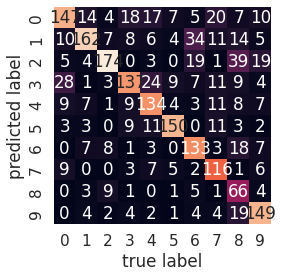

In [ ]:
#confusion matrix ploting
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
mat=confusion_matrix(y_test, y_pred_class)
sns.set(font_scale=1.4)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [ ]:
# example of a precision-recall curve for a predictive model
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt
# predict probabilities
y_scores=Kl.predict_proba(t_X_test)
prec, rec, tre = precision_recall_curve(y_test, y_scores[:,1],)
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

**SVM**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

[[  0   0   0   0   0 211   0   0   0   0]
 [  0   0   0   0   0 205   0   0   0   0]
 [  0   0   0   0   0 208   0   0   0   0]
 [  0   0   0   0   0 190   0   0   0   0]
 [  0   0   0   0   0 207   0   0   0   0]
 [  0   0   0   0   0 181   0   0   0   0]
 [  0   0   0   0   0 212   0   0   0   0]
 [  0   0   0   0   0 189   0   0   0   0]
 [  0   0   0   0   0 184   0   0   0   0]
 [  0   0   0   0   0 213   0   0   0   0]]
precision nan
Recall nan
specificity nan
Accuracy 0.0905


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


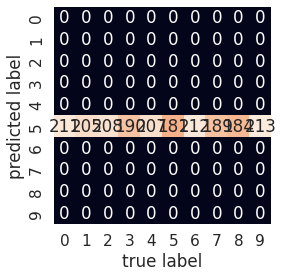

In [ ]:
clf = svm.SVC(kernel='sigmoid', C=1,probability=True).fit(t_X_train, y_train)
clf.score(t_X_test, y_test)
y_pred_class2 = clf.predict(t_X_test)
accuracy2=metrics.accuracy_score(y_test, y_pred_class2)
confusion2 = metrics.confusion_matrix(y_test, y_pred_class2)
print(confusion2)
#[row, column]
TN2 = confusion2[0, 0]
FP2 = confusion2[0, 1]
FN2 = confusion2[1, 0]
TP2 = confusion2[1, 1]
precision2 = TP2 / float(TP2 + FP2)
print("precision",precision2)
Recall2 = TP2 / float(FN2 + TP2)
print("Recall",Recall2)
specificity2 = TN2 / float(TN2 + FP2)
print("specificity",specificity2)
print("Accuracy",accuracy2)
temp_list_accuracy.append(accuracy2)
temp_list_precision.append(precision2)
temp_list_recall.append(Recall2)
#confusion matrix ploting
mat=confusion_matrix(y_test, y_pred_class2)
sns.set(font_scale=1.4)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
# predict probabilities


[[ 49  22   2  34  21  24  10  28   0  21]
 [  8 104   7   2  14   8  30  18  11   3]
 [  7  15 105  13   5   2  22   1  23  15]
 [ 27  14   3  60  17  27   4  29   0   9]
 [ 24  15   4  30  45  31   9  21   2  26]
 [  3   6   3  11   4 129   2  15   1   7]
 [  9  38  28   5   2   3  95   3  17  12]
 [ 11  16   0  10  11  32   5  98   1   5]
 [  2  15  48   4   3   9  38   6  21  38]
 [  8   2  32   4  10   3   6   9  16 123]]
precision 0.8253968253968254
Recall 0.9285714285714286
specificity 0.6901408450704225
Accuracy 0.4145


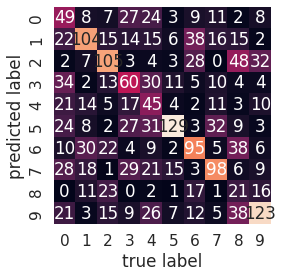

In [ ]:
clf_l = svm.SVC(kernel='linear', C=1,probability=True).fit(t_X_train, y_train)
clf_l.score(t_X_test, y_test)
y_pred_class_3 = clf_l.predict(t_X_test)
accuracy2=metrics.accuracy_score(y_test, y_pred_class_3)
confusion2 = metrics.confusion_matrix(y_test, y_pred_class_3 )
print(confusion2)
#[row, column]
TN2 = confusion2[0, 0]
FP2 = confusion2[0, 1]
FN2 = confusion2[1, 0]
TP2 = confusion2[1, 1]
precision2 = TP2 / float(TP2 + FP2)
print("precision",precision2)
Recall2 = TP2 / float(FN2 + TP2)
print("Recall",Recall2)
specificity2 = TN2 / float(TN2 + FP2)
print("specificity",specificity2)
print("Accuracy",accuracy2)
temp_list_accuracy.append(accuracy2)
temp_list_precision.append(precision2)
temp_list_recall.append(Recall2)
#confusion matrix ploting
mat=confusion_matrix(y_test, y_pred_class_3 )
sns.set(font_scale=1.4)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
# predict probabilities


**Decision tree**

[[  0   0   0   0   0 211   0   0   0   0]
 [  0   0   0   0   0 205   0   0   0   0]
 [  0   0   0   0   0 208   0   0   0   0]
 [  0   0   0   0   0 190   0   0   0   0]
 [  0   0   0   0   0 207   0   0   0   0]
 [  0   0   0   0   0 181   0   0   0   0]
 [  0   0   0   0   0 212   0   0   0   0]
 [  0   0   0   0   0 189   0   0   0   0]
 [  0   0   0   0   0 184   0   0   0   0]
 [  0   0   0   0   0 213   0   0   0   0]]
precision nan
Recall nan
specificity nan
Accuracy 0.0905


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


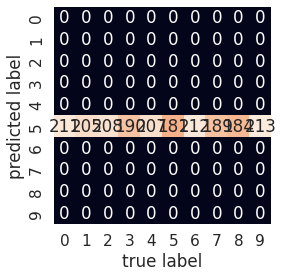

In [ ]:
from sklearn import tree
clf_dt = tree.DecisionTreeClassifier(random_state=100)
clf_dt = clf.fit(t_X_train,y_train)
clf_dt.score(t_X_test, y_test)
y_pred_class_dt = clf.predict(t_X_test)
metrics.accuracy_score(y_test, y_pred_class_dt)
accuracy3=metrics.accuracy_score(y_test, y_pred_class_dt)
confusion3 = metrics.confusion_matrix(y_test, y_pred_class_dt)
print(confusion3)
#[row, column]
TN = confusion3[0, 0]
FP = confusion3[0, 1]
FN = confusion3[1, 0]
TP = confusion3[1, 1]
precision3 = TP / float(TP + FP)
print("precision",precision3)
Recall3 = TP / float(FN + TP)
print("Recall",Recall3)
specificity3 = TN / float(TN + FP)
print("specificity",specificity3)
print("Accuracy", accuracy3)
temp_list_accuracy.append(accuracy3)
temp_list_precision.append(precision3)
temp_list_recall.append(Recall3)
#confusion matrix ploting
mat=confusion_matrix(y_test, y_pred_class_dt)
sns.set(font_scale=1.4)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
# predict probabilities


**Random forest**

Accuracy: 0.697
[[135   8   2  17  21   7   4  17   0   0]
 [  3 160   4   4   5   4  10   7   4   4]
 [  0   6 166   3   2   0  11   1  16   3]
 [ 12   8   1 130  13  10   3  10   0   3]
 [ 14   5   5  17 119  20   9   7   1  10]
 [  4   1   0   3   2 156   2   9   2   2]
 [  2  14  18   3   4   1 157   2   8   3]
 [  8   5   0  11   7  18   5 129   1   5]
 [  0  13  26   4   7   6  29   4  81  14]
 [  6   4  10   2   4   7   8   6   5 161]]
precision 0.9523809523809523
Recall 0.9815950920245399
specificity 0.9440559440559441


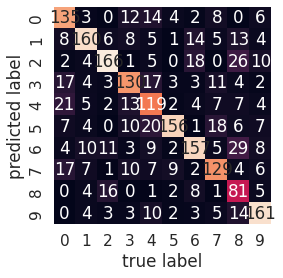

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_rf=RandomForestClassifier(n_estimators=100)
clf_rf.fit(t_X_train,y_train)
y_pred=clf_rf.predict(t_X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
confusion3 = metrics.confusion_matrix(y_test, y_pred)
print(confusion3)
#[row, column]
TN = confusion3[0, 0]
FP = confusion3[0, 1]
FN = confusion3[1, 0]
TP = confusion3[1, 1]
precision3 = TP / float(TP + FP)
print("precision",precision3)
Recall3 = TP / float(FN + TP)
print("Recall",Recall3)
specificity3 = TN / float(TN + FP)
print("specificity",specificity3)
temp_list_accuracy.append(accuracy3)
temp_list_precision.append(precision3)
temp_list_recall.append(Recall3)
#confusion matrix ploting
mat=confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
# predict probabilities

Accuracy: 0.683
[[135  10   2  18  16   6   4  19   1   0]
 [  4 153   5   3   6   2  17   8   4   3]
 [  4   5 170   4   3   0   8   1  11   2]
 [ 16   9   0 119  18  13   2   8   1   4]
 [ 13   6   3  20 122  17   8   7   1  10]
 [  5   1   0   3   2 157   0   8   3   2]
 [  5  23  18   6   1   0 146   2   5   6]
 [ 10   8   0  11   8  20   3 121   2   6]
 [  2  15  30   2   5   5  24   2  82  17]
 [  6   4   9   4   3   5   8   5   8 161]]
precision 0.9386503067484663
Recall 0.9745222929936306
specificity 0.9310344827586207


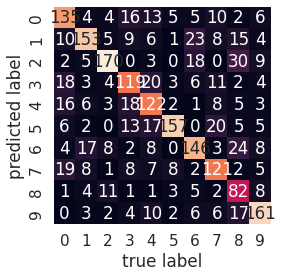

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_rf=RandomForestClassifier(n_estimators=50)
clf_rf.fit(t_X_train,y_train)
y_pred=clf_rf.predict(t_X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
confusion3 = metrics.confusion_matrix(y_test, y_pred)
print(confusion3)
#[row, column]
TN = confusion3[0, 0]
FP = confusion3[0, 1]
FN = confusion3[1, 0]
TP = confusion3[1, 1]
precision3 = TP / float(TP + FP)
print("precision",precision3)
Recall3 = TP / float(FN + TP)
print("Recall",Recall3)
specificity3 = TN / float(TN + FP)
print("specificity",specificity3)
temp_list_accuracy.append(accuracy3)
temp_list_precision.append(precision3)
temp_list_recall.append(Recall3)
#confusion matrix ploting
mat=confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
# predict probabilities

Accuracy: 0.6995
[[138   9   2  17  14   6   3  21   0   1]
 [  3 160   4   4   5   2  12   7   5   3]
 [  0   5 167   5   3   0  12   0  14   2]
 [ 10   6   0 129  16  14   3  10   0   2]
 [ 16   5   5  16 123  19   7   6   1   9]
 [  5   2   0   5   0 157   2   7   2   1]
 [  6  13  18   2   1   1 157   4   8   2]
 [  8   4   0   9   7  20   4 131   0   6]
 [  1  16  32   4   4   6  28   2  73  18]
 [  5   4  10   1   4   7   8   6   4 164]]
precision 0.9467455621301775
Recall 0.9815950920245399
specificity 0.9387755102040817


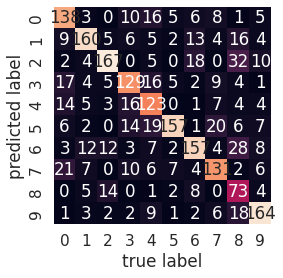

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_rf=RandomForestClassifier(n_estimators=400)
clf_rf.fit(t_X_train,y_train)
y_pred=clf_rf.predict(t_X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
confusion3 = metrics.confusion_matrix(y_test, y_pred)
print(confusion3)
#[row, column]
TN = confusion3[0, 0]
FP = confusion3[0, 1]
FN = confusion3[1, 0]
TP = confusion3[1, 1]
precision3 = TP / float(TP + FP)
print("precision",precision3)
Recall3 = TP / float(FN + TP)
print("Recall",Recall3)
specificity3 = TN / float(TN + FP)
print("specificity",specificity3)
temp_list_accuracy.append(accuracy3)
temp_list_precision.append(precision3)
temp_list_recall.append(Recall3)
#confusion matrix ploting
mat=confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
# predict probabilities

Accuracy: 0.7035
[[140   9   1  19  14   4   4  20   0   0]
 [  4 156   3   5   5   3  14   6   5   4]
 [  2   4 167   4   1   0  10   0  18   2]
 [ 11   5   1 128  15  16   2   9   0   3]
 [ 14   4   5  15 126  18   8   7   2   8]
 [  5   1   0   5   0 157   3   7   2   1]
 [  3  13  17   4   1   0 158   4   8   4]
 [  6   6   1   9   6  16   3 138   0   4]
 [  1  15  30   4   5   6  28   2  79  14]
 [  3   3  12   3   3   6   9   8   8 158]]
precision 0.9454545454545454
Recall 0.975
specificity 0.9395973154362416


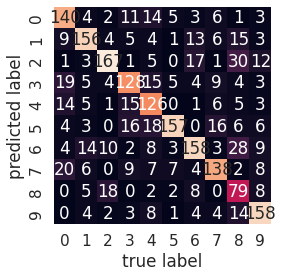

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_rf=RandomForestClassifier(n_estimators=150)
clf_rf.fit(t_X_train,y_train)
y_pred=clf_rf.predict(t_X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
confusion3 = metrics.confusion_matrix(y_test, y_pred)
print(confusion3)
#[row, column]
TN = confusion3[0, 0]
FP = confusion3[0, 1]
FN = confusion3[1, 0]
TP = confusion3[1, 1]
precision3 = TP / float(TP + FP)
print("precision",precision3)
Recall3 = TP / float(FN + TP)
print("Recall",Recall3)
specificity3 = TN / float(TN + FP)
print("specificity",specificity3)
temp_list_accuracy.append(accuracy3)
temp_list_precision.append(precision3)
temp_list_recall.append(Recall3)
#confusion matrix ploting
mat=confusion_matrix(y_test, y_pred)
sns.set(font_scale=1.4)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');
# predict probabilities

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf_rf=RandomForestClassifier(n_estimators=300)
clf_rf.fit(t_X_train,y_train)
y_pred=clf_rf.predict(t_X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
confusion3 = metrics.confusion_matrix(y_test, y_pred)
print(confusion3)
#[row, column]
TN = confusion3[0, 0]
FP = confusion3[0, 1]
FN = confusion3[1, 0]
TP = confusion3[1, 1]
precision3 = TP / float(TP + FP)
print("precision",precision3)
Recall3 = TP / float(FN + TP)
print("Recall",Recall3)
specificity3 = TN / float(TN + FP)
print("specificity",specificity3)
# temp_list_accuracy.append(accuracy3)
# temp_list_precision.append(precision3)
# temp_list_recall.append(Recall3)
# #confusion matrix ploting
# mat=confusion_matrix(y_test, y_pred)
# sns.set(font_scale=1.4)
# sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
# plt.xlabel('true label')
# plt.ylabel('predicted label');
# # predict probabilities

Accuracy: 0.683
[[204  14   1  24  13  12   3  30   1   4]
 [  5 228   6   4   5   5  14  18   6   3]
 [  4   4 235   6   4   2  19   1  30   5]
 [ 18  16   0 179  22  25   5  11   0   4]
 [ 26  12   4  27 182  26  12  10   1  11]
 [  5   3   0   4   0 254   4  14   2   6]
 [  8  22  28   6   3   0 228   5  12   9]
 [ 10  12   0   9  16  29   3 191   1   7]
 [  5  24  38   9   5   8  45   5 124  33]
 [ 14   7  16   2   7   7  13   9  13 224]]
precision 0.9421487603305785
Recall 0.9785407725321889
specificity 0.9357798165137615
